#**CSE164 Code Exercise - Semi-supervised Learning**
This notebook provides illustrative code template to a basic semi-supervised learning technique.

You may find some useful information about google colab and opencv here: [Colab](https://colab.research.google.com/notebooks/welcome.ipynb) and [OpenCV](https://opencv.org/)

> credit to: https://keras.io/examples/vision/mnist_convnet/ and https://github.com/beresandras/semisupervised-classification-keras

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from functools import partial
import copy
import csv

#Unzip data folder if using google colab online
# !unzip ucsc-cse-164-spring-2022-final-project.zip


Fix Seed for Reproducible Results
==================

In [2]:
seed = 1
np.random.seed(seed)
tf.random.set_seed(seed)

Load Data
==================

> Only a semisupervised binary classification task is performed in this code. So only data of a specific two classes are selected, and then partitioned into a labeled set and an unlabeled set

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5}
x_train shape: (60, 64, 64, 1)
60 train samples
y_train shape: (60, 6)


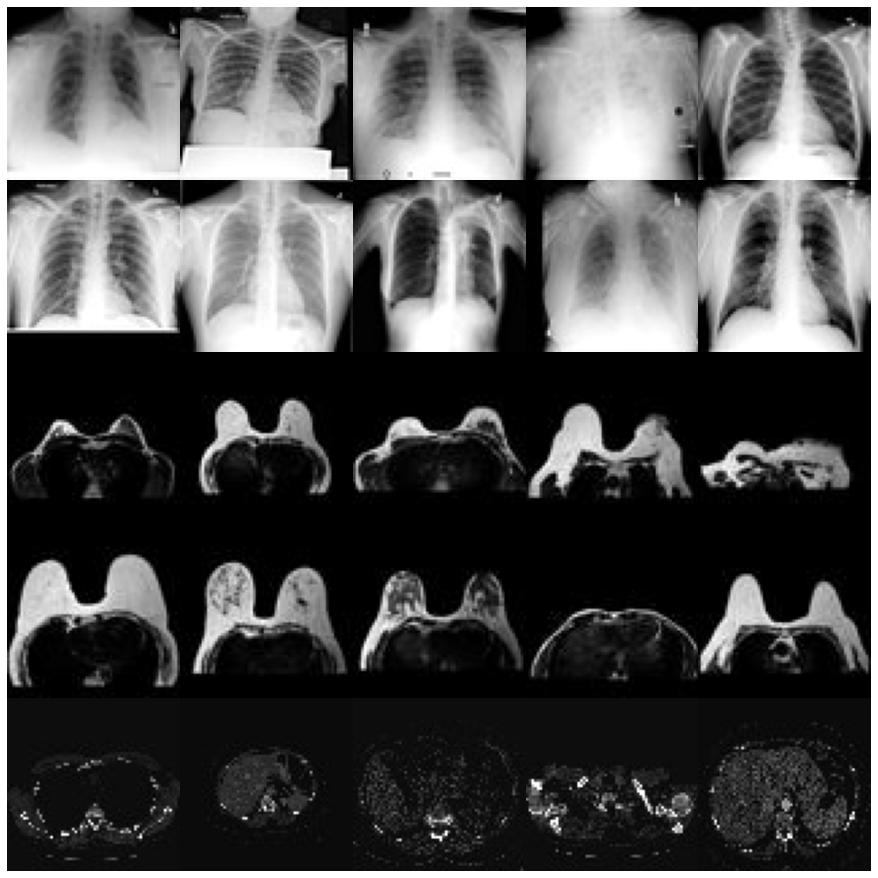

In [3]:
from PIL import Image
from matplotlib import pyplot as plt
import os

def load_image(file_path):
    img = Image.open(file_path).convert("L")
    w, h = img.size
    if w != 64 or h != 64:
      img = img.resize((64,64), Image.ANTIALIAS)
    img.load()
    data = np.asarray(img, dtype="int32")
    return data

def plot_25_imgs(img_lst):
    f, axarr = plt.subplots(5, 5)
    f.set_size_inches(12, 12)
    f.subplots_adjust(wspace=0, hspace=0, left=0, right=1, top=1, bottom=0)
    for i in range(25):
        axarr[i // 5, i % 5].axis("off")
        axarr[i // 5, i % 5].imshow(img_lst[i],cmap="gray")

label_dict = {}
for i, line in enumerate(open("MedMNIST/wnids.txt", "r")):
  label_dict[line.rstrip("\n")] = i

print(label_dict)

label_directory = 'MedMNIST/lableed'
unlabel_directory = 'MedMNIST/unlabeled'
test_directory= 'MedMNIST/test'

img_lst = []    # save img_as numpy.array object
label_lst = []  # save labels of imgs as numpy.array object
for label in os.scandir(label_directory):
  if label.is_dir():
    for img in os.scandir(label.path):
      img_lst.append(load_image(img.path))
      label_lst.append(label_dict[label.name])

plot_25_imgs(img_lst)

# Model / data parameters
num_classes = len(label_dict)
input_shape = (64, 64, 1)
# input_shape = (224, 224, 1)

# Initialize labeled X and Y data for training
# And Scale images to the [0, 1] range
(labeled_x_train, labeled_y_train) = (np.array(img_lst, dtype=np.float32)/255, np.array(label_lst))

# Add one more dimension
labeled_x_train = np.expand_dims(labeled_x_train, -1)

print("x_train shape:", labeled_x_train.shape)
print(labeled_x_train.shape[0], "train samples")

# convert class vectors to 6 class matrices
labeled_y_train = keras.utils.to_categorical(labeled_y_train, num_classes)

print("y_train shape:", labeled_y_train.shape)

Class Selection
==================

In [4]:
test_img_lst = []
# test_label_lst = []
img_ids = []
for img in os.scandir(test_directory):
  test_img_lst.append(load_image(img.path))
  name_len = (len(img.name))

  # Remove .jpeg from name
  img_ids.append(img.name[:name_len-5])

x_test = np.array(test_img_lst, dtype=np.float32)/255
# Add one more dimension for img
x_test= np.expand_dims(x_test, -1)

print("Shape of test imgs: ", x_test.shape)

Shape of test imgs:  (6000, 64, 64, 1)


Labeled vs Unlabeled Set Partition
==================

In [5]:
# Read all unlabeled training imgs
unlabeled_img_lst = []

for img in os.scandir(unlabel_directory):
  unlabeled_img_lst.append(load_image(img.path))


unlabeled_x_train= np.array(unlabeled_img_lst, dtype=np.float32)/255
unlabeled_x_train = np.expand_dims(unlabeled_x_train, -1)

print("Shape of unlabeled train imgs: ",unlabeled_x_train.shape)


Shape of unlabeled train imgs:  (49834, 64, 64, 1)


Create Dataset
==================

In [6]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 500

labeled_train_dataset = tf.data.Dataset.from_tensor_slices((labeled_x_train, labeled_y_train))
labeled_train_dataset = labeled_train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

# unlabeled_train_dataset = tf.data.Dataset.from_tensor_slices((unlabeled_x_train, unlabeled_y_train))
unlabeled_train_dataset = tf.data.Dataset.from_tensor_slices(unlabeled_x_train)
unlabeled_train_dataset = unlabeled_train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

train_dataset = tf.data.Dataset.zip((unlabeled_train_dataset, labeled_train_dataset)) #.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = tf.data.Dataset.from_tensor_slices(x_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

Training Step and Loss
==================

In [7]:
class SemisupervisedModel(keras.Model):
    def __init__(self, model, entropy=False, lamda=0.1):
        super().__init__()

        self.model = model
        self.cce = tf.keras.losses.CategoricalCrossentropy()

        self.entropy = entropy
        self.lamda = lamda

    def compile(self, optimizer, **kwargs):
        super().compile(**kwargs)

        self.optimizer = optimizer
        self.accuracy_tracker = keras.metrics.Accuracy()
        self.loss_tracker = keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker, self.accuracy_tracker]
        # return [self.loss_tracker]

    def call(self, images, training=True):
        return self.model(images, training=training)

    # def semisupervised_loss(self, labeled_y_true, labeled_y_pred, unlabeled_y_true, unlabeled_y_pred):
    #     loss = self.cce(labeled_y_true, labeled_y_pred)
    #     if self.entropy:
    #         loss += -self.lamda * tf.reduce_mean(tf.reduce_sum(unlabeled_y_pred * tf.math.log(unlabeled_y_pred + 1e-12), axis=1))
    #     return loss

    def semisupervised_loss(self, labeled_y_true, labeled_y_pred):
        loss = self.cce(labeled_y_true, labeled_y_pred)
        # if self.entropy:
        #     loss += -self.lamda * tf.reduce_mean(tf.reduce_sum(unlabeled_y_pred * tf.math.log(unlabeled_y_pred + 1e-12), axis=1))
        return loss

    def train_step(self, data):
        # (unlabeled_images, unlabeled_y_true), (labeled_images, labeled_y_true) = data
        (unlabeled_images), (labeled_images, labeled_y_true) = data


        with tf.GradientTape() as tape:
            labeled_y_pred = self.call(labeled_images, training=True)
            unlabeled_y_pred = self.call(unlabeled_images, training=True)
            # loss = self.semisupervised_loss(labeled_y_true, labeled_y_pred, unlabeled_y_true, unlabeled_y_pred)
            loss = self.semisupervised_loss(labeled_y_true, labeled_y_pred)
        gradients = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))
        self.loss_tracker.update_state(loss)

        # self.accuracy_tracker.update_state(tf.math.argmax(unlabeled_y_true, axis=1), tf.math.argmax(unlabeled_y_pred, axis=1))
        self.accuracy_tracker.update_state(tf.math.argmax(labeled_y_true, axis=1), tf.math.argmax(labeled_y_pred, axis=1))

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        # images, labels = data
        images = data
        y_pred = self.call(images, training=False)

        # loss = self.cce(labels, y_pred)
        # self.loss_tracker.update_state(loss)

        # self.accuracy_tracker.update_state(tf.math.argmax(labels, axis=1), tf.math.argmax(y_pred, axis=1))

        return {m.name: m.result() for m in self.metrics}

Semi-supervised Learning
==========================

In [32]:
semi_model = SemisupervisedModel(
    keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
    ),
    entropy=True
)

In [33]:
# More epoches can be helful here
epochs = 30

semi_model.compile(optimizer=keras.optimizers.Adam(), metrics=["accuracy"])

semi_model.fit(train_dataset, epochs=epochs)

Epoch 1/30
1/1 [==============================] - 1s 927ms/step - loss: 1.8075 - accuracy: 0.1667
Epoch 2/30
1/1 [==============================] - 0s 335ms/step - loss: 1.6472 - accuracy: 0.3167
Epoch 3/30
1/1 [==============================] - 0s 313ms/step - loss: 1.5345 - accuracy: 0.4333
Epoch 4/30
1/1 [==============================] - 0s 452ms/step - loss: 1.4164 - accuracy: 0.5833
Epoch 5/30
1/1 [==============================] - 0s 443ms/step - loss: 1.2675 - accuracy: 0.6333
Epoch 6/30
1/1 [==============================] - 0s 453ms/step - loss: 1.0678 - accuracy: 0.7000
Epoch 7/30
1/1 [==============================] - 0s 443ms/step - loss: 0.9233 - accuracy: 0.8333
Epoch 8/30
1/1 [==============================] - 0s 452ms/step - loss: 0.7611 - accuracy: 0.9000
Epoch 9/30
1/1 [==============================] - 0s 439ms/step - loss: 0.6262 - accuracy: 0.8833
Epoch 10/30
1/1 [==============================] - 0s 303ms/step - loss: 0.5544 - accuracy: 0.8833
Epoch 11/30
1/1 [==

In [34]:

y_predict = semi_model.predict(test_dataset)
# print("Test loss:", score[0])
# print("Test accuracy:", score[1])
# print(y_predict[:20])
print(y_predict.shape)
result_labels = []
for l in list(np.argmax(y_predict, axis=1)):
  result_labels.append(str(l))
# print(result_labels)

csv_file = open('./predict.csv', 'w')
rows = zip(img_ids, result_labels)
with csv_file:   
    write = csv.writer(csv_file)
    # for i in range(len(result_labels)):
    write.writerow(("image_id","label"))
    for r in rows:
      # print(r)
      write.writerow(r)

print("Prediction has been written in to predict.csv!")
csv_file.close()
files.download("predict.csv")

#  Get the final model file
from google.colab import files
semi_model.save("Final_Model_Erjie_Zhang") 
!zip -r /content/Final_Model_Erjie_Zhang.zip /content/Final_Model_Erjie_Zhang
files.download("Final_Model_Erjie_Zhang.zip")


(6000, 6)
Prediction has been written in to predict.csv!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

INFO:tensorflow:Assets written to: Final_Model_Erjie_Zhang/assets
updating: content/Final_Model_Erjie_Zhang/ (stored 0%)
updating: content/Final_Model_Erjie_Zhang/saved_model.pb (deflated 89%)
updating: content/Final_Model_Erjie_Zhang/variables/ (stored 0%)
updating: content/Final_Model_Erjie_Zhang/variables/variables.data-00000-of-00001 (deflated 7%)
updating: content/Final_Model_Erjie_Zhang/variables/variables.index (deflated 63%)
updating: content/Final_Model_Erjie_Zhang/assets/ (stored 0%)
updating: content/Final_Model_Erjie_Zhang/keras_metadata.pb (deflated 89%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

TODO
======================

> Experiment with different unlabeled ratio, and different lambda. Note the baseline performace may vary a lot depending on the labeled set partition.